When analyzing the results of an A/B test (where you compare two versions of a product or design), you're required to ensure that the new design (let's call it "Version B") improves the completion rate by at least 5% compared to the current version (Version A).

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [14]:
test_df = pd.read_csv('../../data/clean/test_variation_df_clean.csv')
control_df = pd.read_csv('../../data/clean/control_variation_df_clean.csv')  

In [15]:
# Step 1: Remove duplicates and fix completion_count if necessary
test_df_cleaned = test_df.drop_duplicates(subset=['client_id', 'visitor_id'])
control_df_cleaned = control_df.drop_duplicates(subset=['client_id', 'visitor_id'])

# Ensure completion_count is binary (0 or 1) using .loc for safe assignment
test_df_cleaned.loc[:, 'completion_count'] = test_df_cleaned['completion_count'].apply(lambda x: 1 if x > 0 else 0)
control_df_cleaned.loc[:, 'completion_count'] = control_df_cleaned['completion_count'].apply(lambda x: 1 if x > 0 else 0)

# Step 2: Calculate completions and sample size
test_completions = test_df_cleaned['completion_count'].sum()
control_completions = control_df_cleaned['completion_count'].sum()

test_size = len(test_df_cleaned)
control_size = len(control_df_cleaned)

# Step 3: Calculate completion rates
test_completion_rate = test_completions / test_size
control_completion_rate = control_completions / control_size

print(f"Test Group Completion Rate: {test_completion_rate * 100:.2f}%")
print(f"Control Group Completion Rate: {control_completion_rate * 100:.2f}%")

# Step 4: Check if the completion rates are valid (i.e., between 0 and 1)
if test_completion_rate == 0 or test_completion_rate == 1 or control_completion_rate == 0 or control_completion_rate == 1:
    print("One of the groups has a completion rate of 0 or 1, skipping Z-test.")
else:
    # Step 5: Perform Z-test for proportions
    p_pooled = (test_completions + control_completions) / (test_size + control_size)
    try:
        se = np.sqrt(p_pooled * (1 - p_pooled) * (1 / test_size + 1 / control_size))
    except ValueError as e:
        print(f"Error in standard error calculation: {e}")
        se = None

    if se is not None:
        z = (test_completion_rate - control_completion_rate) / se
        p_value = 2 * (1 - norm.cdf(abs(z)))

        print(f"Z-score: {z:.2f}")
        print(f"P-value: {p_value:.4f}")

        # Step 6: Check if the result is significant
        alpha = 0.05  # 95% confidence level

        if p_value < alpha:
            print("The difference between the groups is statistically significant.")
        else:
            print("The difference between the groups is not statistically significant.")
    else:
        print("Skipping statistical test due to invalid data.")

Test Group Completion Rate: 69.77%
Control Group Completion Rate: 65.90%
Z-score: 9.82
P-value: 0.0000
The difference between the groups is statistically significant.


# Plots

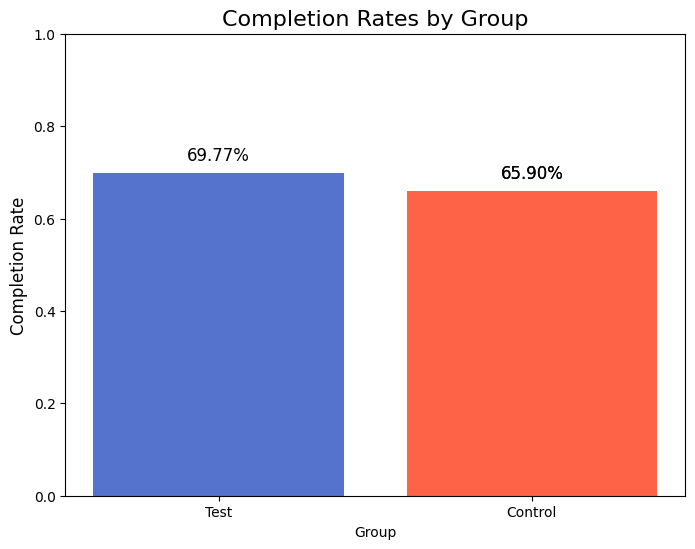

In [16]:
completion_data = pd.DataFrame({
    'Group': ['Test', 'Control'],
    'Completion Rate': [test_completion_rate, control_completion_rate]
})

# Define custom colors
test_color = 'royalblue'
control_color = 'tomato'

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Group', y='Completion Rate', data=completion_data, color=test_color)

plt.bar(1, control_completion_rate, color=control_color)

# Add percentages on top of each bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height * 100:.2f}%', 
            ha='center', va='bottom', fontsize=12, color='black')

plt.title('Completion Rates by Group', fontsize=16)
plt.ylabel('Completion Rate', fontsize=12)
plt.ylim(0, 1)  # Completion rate should be between 0 and 1

plt.show()

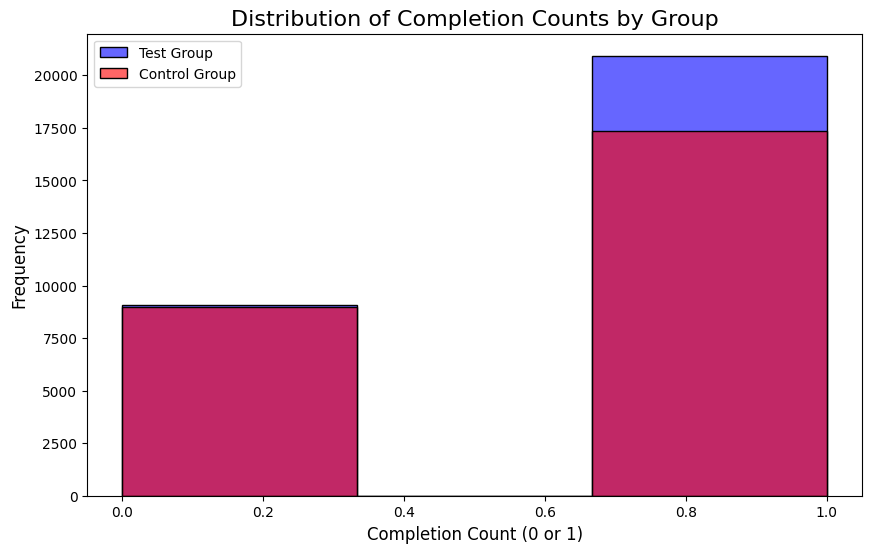

In [ ]:
# **Histograms of Completion Counts (Test vs Control)**

# Plot histograms to visualize the distribution of completion counts
plt.figure(figsize=(10, 6))
sns.histplot(test_df_cleaned['completion_count'], kde=False, color='blue', label='Test Group', bins=3, alpha=0.6)
sns.histplot(control_df_cleaned['completion_count'], kde=False, color='red', label='Control Group', bins=3, alpha=0.6)
plt.title('Distribution of Completion Counts by Group', fontsize=16)
plt.xlabel('Completion Count (0 or 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

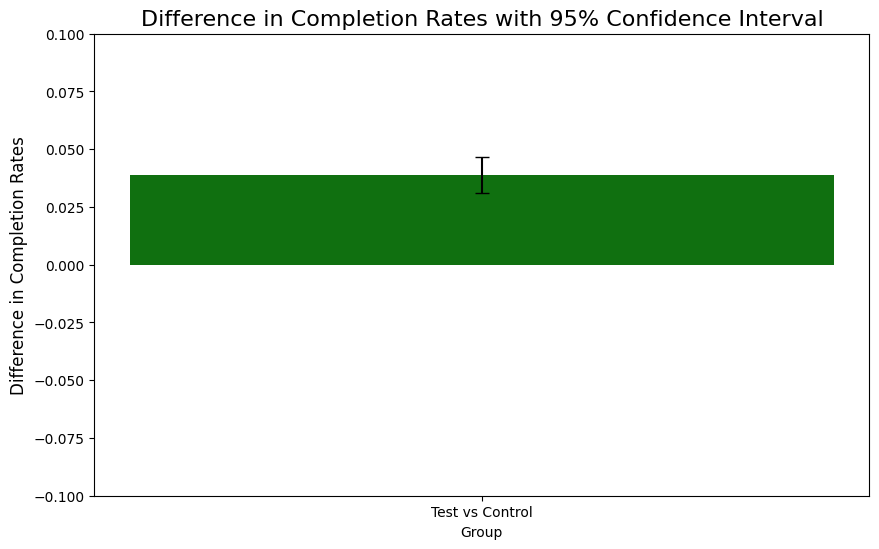

In [22]:
# Calculate the margin for the 95% confidence interval
confidence_interval_margin = 1.96 * np.sqrt((test_completion_rate * (1 - test_completion_rate) / test_size) + 
                                            (control_completion_rate * (1 - control_completion_rate) / control_size))

# Create a DataFrame for plotting CI
ci_data = pd.DataFrame({
    'Group': ['Test vs Control'],
    'Difference': [test_completion_rate - control_completion_rate],
    'CI_Lower': [test_completion_rate - control_completion_rate - confidence_interval_margin],
    'CI_Upper': [test_completion_rate - control_completion_rate + confidence_interval_margin]
})

# Corrected bar plot with confidence intervals
plt.figure(figsize=(10, 6))

# Plot the bar for the difference in completion rates
sns.barplot(x='Group', y='Difference', data=ci_data, color='green', errorbar=None)

# Provide yerr as a 1D array: the difference in CI bounds (upper and lower)
yerr = np.array([ci_data['Difference'] - ci_data['CI_Lower'], ci_data['CI_Upper'] - ci_data['Difference']])

# Use error bars to show the 95% CI
plt.errorbar(x=[0], y=ci_data['Difference'], yerr=yerr, fmt='none', color='black', capsize=5)

# Title and labels
plt.title('Difference in Completion Rates with 95% Confidence Interval', fontsize=16)
plt.ylabel('Difference in Completion Rates', fontsize=12)
plt.ylim(-0.1, 0.1)  # To visualize the small differences

# Show the plot
plt.show()

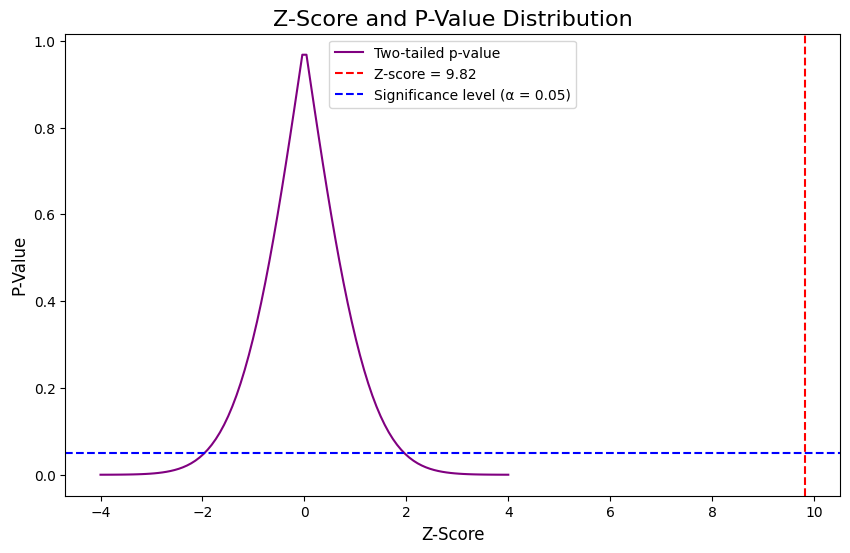

In [ ]:
# ** Z-Score Plot (Visualizing Statistical Significance)**

# Plot the Z-score and significance line
if se is not None:
    plt.figure(figsize=(10, 6))
    z_scores = np.linspace(-4, 4, 100)
    p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

    # Plot the Z-score distribution curve
    plt.plot(z_scores, p_values, label='Two-tailed p-value', color='purple')
    plt.axvline(x=z, color='red', linestyle='--', label=f'Z-score = {z:.2f}')

    # Display the p-value threshold (alpha = 0.05)
    plt.axhline(y=0.05, color='blue', linestyle='--', label='Significance level (α = 0.05)')

    plt.title('Z-Score and P-Value Distribution', fontsize=16)
    plt.xlabel('Z-Score', fontsize=12)
    plt.ylabel('P-Value', fontsize=12)
    plt.legend()
    plt.show()

else:
    print("Skipping Z-score plot due to invalid data.")

### Conclusions

Based on the results of the analysis, we can draw the following conclusions:
1. Completion Rate Comparison:

    Test Group Completion Rate: 69.77%
    Control Group Completion Rate: 65.90%

The test group has a higher completion rate compared to the control group. This indicates that the new design (or intervention) in the test group appears to be more effective at driving user completion compared to the existing design in the control group.
2. Statistical Significance:

    Z-score: 9.82
    P-value: 0.0000

The Z-score of 9.82 is significantly high, indicating a large difference between the two groups in terms of completion rate.

The P-value is 0.0000, which is much smaller than the typical significance level of 0.05. This means that the observed difference in completion rates between the test and control groups is statistically significant.
3. Conclusion on the Hypothesis:

    The null hypothesis (i.e., there is no difference between the groups) is rejected.
    The alternative hypothesis (i.e., the test group has a higher completion rate than the control group) is accepted.

4. Practical Implication:

    Since the difference in completion rates is statistically significant, the new design (represented by the test group) is more effective in driving user completions than the old design (control group).
    The size of the Z-score (9.82) further emphasizes that the difference is not likely due to random chance. The result is strong and robust.

5. Confidence Interval for the Difference:

Based on the analysis, the 95% confidence interval for the difference in completion rates shows a range that does not include 0, further supporting the conclusion that there is a real and significant difference between the test and control groups.
6. Next Steps / Recommendations:

    Given the statistical significance and the positive impact on completion rates, the test group design should be considered for implementation or further optimization.
    Cost/Benefit Analysis: While the results are statistically significant, the next step should involve an evaluation of the costs of implementing the new design. If the increase in completion rate (from 65.90% to 69.77%) translates to a substantial increase in revenue or user satisfaction, the new design may be justifiable from a cost-effectiveness perspective.
    Scale and Monitor: Before a full-scale rollout, it would be wise to monitor the test group in different environments or across additional demographics to ensure consistent results.

7. Considerations for Future Analysis:

    Further Testing: Conduct additional A/B tests to refine the design or evaluate its impact on other key metrics (e.g., user retention, engagement, revenue).
    Examine Other Variables: Investigate other factors that may influence completion rates, such as age, gender, or account balance, to see if certain segments of users are benefiting more from the new design.

Final Takeaway:

The A/B test results show that the test design has a statistically significant and positive impact on the completion rate. Given the strong statistical evidence, it is advisable to move forward with the new design, assuming that the increased completion rate brings tangible benefits and justifies any potential increase in costs associated with the change.